# Intro

Supervised ML focuses on prediction, but it is actions that influence the world. Predictions can be useful inputs into decision-making, but decision-making involves a subsequent optimization step which we currently devote less energy to.

Reinforcement learning (RL) directly optimizes actions. But RL research is focused on very different problems than those where supervised ML is providing value today. This notebook shows a decision optimization workflow designed for mainstream business applications. 

My interactions with data scientists outside the tech giants convince me that this approach will add at least as much value as businesses have received from adopting supervised ML so far.

The workflow is:
1. Encode a practitioners domain knowledge into a model. This model can be a system of multiple equations, depicting different moving parts of the business environment.
2. Use existing data to estimate parameters of the relationships described in the model. More detail on this below.
3. Treat the estimated model as a simulation environment. Optimize the decision policy in this simulation environment.
4. Apply that decision policy in the real business environment

Theory suggests optimization will be more robust if we estimate the posterior from a Bayesian model, and then sample from that posterior in the simulator. The results of the single example in this notebook are consistent with that. I believe this use of a Bayesian model will be especially valuable in more complex business applications or those with small datasets.

### Differences from Conventional RL

This approach differs from mainstream RL in 3 ways:

1. The RL community generally eschews human engineered models. I go the opposite direction, relying on human knowledge to structure the model.

2. RL research is computationally difficult because it is applied to problems with high dimensional state spaces (e.g. robotics and video games). I focus on problems where state spaces are several orders of magnitude smaller. Optimization is much easier in such low dimensional spaces.

3. Conventional RL agents learn by interacting directly with the environment. But no business would deploy an untrained agent to experiment with important business decisions. Instead, I do optimization offline (in the simulator). Only the optimized policy would be deployed to a real environment.

> Though I use a model, this workflow is not conventional model-based reinforcement learning. Specifically, the model of the environment isn't updated during policy optimization. This difference flows from the goal of doing policy optimization outside the real environment.
This approach is closer to [World Models](https://arxiv.org/abs/1803.10122). But World Models avoids human knowledge when building the simulator, relying instead on standard deep learning models. My approach would fail in the World Models testbed (a video game) because humans have little intuition in the pixel space. But humans have good intuitions about the problems I aim to solve, and that knowledge is a beneficial regularizer in my proposed workflow.

# Example: Airline Pricing
Airlines already use machine learning to help set ticket prices. An ML model predicts how many tickets the airline can sell each day for each upcoming flight for each candidate price. The model considers price, seasonablity, competitor prices, macroeconomic variables, etc. But even a perfect predictive model wouldn't guarantee efficient price setting.

For example, consider a flight happening in 100 days with 150 unsold seats. A predictive model says you can sell 1 ticket today for \\$300 or you could sell 2 tickets if you set the price at $250. Which price should you choose?

Airlines currently convert predictive models into pricing decisions with shockingly simple heuristics (e.g. a table of how many tickets to sell at pre-specified periods before the flight)

This notebook trains an agent to set prices through explicit optimization.

To illustrate the how the resulting pricing policy performs in the original data generating environment, I simulate the data generating process rather than using real data. For illustrative simplicity, this example considers a market with only two airlines. I train an agent to set prices for Jetblue, facing a competitor called Delta.

# Implementation Overview

**This example has enough code that I import most of it as a Python package stored rather than cluttering the notebook with it. The imported package is at [https://github.com/dansbecker/sem_policy_opt](https://github.com/dansbecker/sem_policy_opt).**

The most important class in this package is the [Market](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/market.py) class. The Market contains the parts of the problem that a domain expert can specify. It defines the state variables and any deterministic transition rules.

The key facts encoded in this particular example are:

Each flight starts with a fixed number of available seats and a fixed number of days to departure. 

Each day until the flight happens
- the number of seats available decreases by the number of seats that airline sells
- the number of days until the flight decreases by 1
- accumulated revenue for the flight increases by `ticket_price * seats_sold`
- airlines cannot sell more seats than the plane has, and sales stop when the plane takes off (this model ignores overbooking, though someone more knowledgeable might model that too)

I expect this set of rules to be more complex in most practical applications, ideally encoding as much domain knowledge as possible.

A **predictive model** captures the sources of uncertainty in the environment:
- How a competitor sets prices
- How many seats each airline will sell on each day (as a function of daily demand shocks and each airline's price)

I first use the conventional deep learning model [defined here](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/keras_models.py). I then compare it to the Bayesian neural network [defined here](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/pymc_models.py).

The Market class (aka the "structural model") is completely deterministic once it receives the predictions from the predictive model. The basic operations of the **Market** class follow the OpenAI Gym compatible API, so standard RL libraries can be used for optimization.

> Aside: The field of structural econometrics has historically incorporated all uncertainty into the structural model, rather than pushing uncertainty into a separate predictive model. This requires specifying functional forms in the structural model and estimating those parameters directly (e.g. with maximum likelihood estimation). That workflow has the standard shorcomings of GLM style modeling (e.g. underfitting). Abstracting uncertainty into a predictive model provides the flexibility to use more modern ML models.

Lastly, I generate the data with logic encoded in a [RealDGP](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/true_dgp.py) object. For interoperability, it uses a method called `predict` similar to the predictive models, though the internal mechanism used to generate the data is much different from the mechanism of a predictive model.

In [2]:
# install package with market logic, predictive models and utility functions
!pip install git+https://github.com/dansbecker/sem_policy_opt

# Import functionality we will need later from package
from sem_policy_opt.diagnostics import plot_optim_results, r_squared, \
                                       pricing_fn_creator, eval_pricing_fns, \
                                       model_comparison_plot
from sem_policy_opt.keras_models import WrappedKerasModel
from sem_policy_opt.market import Market
from sem_policy_opt.pymc_models import WrappedPymcModel
from sem_policy_opt.run_env import run_env
from sem_policy_opt.real_dgp import RealDGP

# Step 1: Collect Data From Real Market

I define parameters and import a pricing function for use in the true data generating process. The exact market mechanisms (which the constants below affect) aren't central to explaining my modeling and optimization approach. You can treat the quantity-determining mechanism and it's parameters as a black box, much as the airlines do.

In [3]:
import numpy as np
import pandas as pd

from matplotlib import style
style.use('fivethirtyeight')

# market_details specifies parameters of data generating process (hidden from predictive models)
market_details = dict(
    # parameters the airlines do not observe
    customer_level_randomness = 25, # measures customer level variation in airline preferences
    demand_signal_noisiness = 25,   # Std. Dev of noise in airlines' estimate of daily traffic shocks
    max_demand_level = 400,         # The most any customer will ever pay
    potential_customers_per_day = 15, # Number of unique people making ticket purchase decisions
    # parameters the airlines observe
    seats_per_flight = 200,
    sales_window_length = 100       # Length of time airline has to sell tickets before flight takes off
)

flights_in_training_data = 100 # Number of flights airline can collect training data from 
flights_in_val_data = 10       # number of flights worth of data the airline has for validation


I used trial and error to find a reasonable pricing function. I use the following function for both airlines when creating "real" data.

In [4]:
def simple_price_fn(my_demand_signal, days_before_flight, my_seats_avail, competitor_full): 
    # Charge more if you have a lot of time to sell seats, if few seats are available, or if you have little competition
    # On net, prices may increase over time because low seat inventory overwhelms remaining time effect.
    formula_price = 40 + my_demand_signal + 0.5 * days_before_flight - my_seats_avail + 40 * int(competitor_full)
    # demand_signal is noisy and can thus be negative. Never price tickets below some price_floor
    price_floor = 10
    actual_price = max(formula_price, price_floor)
    return actual_price

# Step 1: Collect Training Data from Real Market

Airlines have historical data they can use to build a model. Here, I run the "real" environment to create training data.

In [5]:

real_dgp = RealDGP(delta_price_fn = simple_price_fn) # Assume Delta uses price_fn defined above

real_market = Market(real_dgp, market_details) 

train_profits, train_data = run_env(real_market, simple_price_fn, n_times=flights_in_training_data)
val_profits, val_data = run_env(real_market, simple_price_fn, n_times=flights_in_val_data)

# Step 2: Fit Predictive Model on Real Data

We use the training data to fit a model that predicts Delta's price and both airlines' quantity sold as a function of
- Days remaining
- Jetblue's demand signal
- Jetblue's remaining number of seats available
- Whether Delta's flight is fully booked (i.e. whether Delta is still selling tickets)


In [6]:
predictive_model = WrappedKerasModel(train_data)

print('r-squared values for predictive model:')
r_squared(predictive_model, val_data)

r-squared values for predictive model:


{'delta_price': 0.82, 'jb_qty_sold': 0.51, 'delta_qty_sold': 0.43}

# Step 3: Set Up Model-Based Market Simulator

I create a market simulator based on the predictive model (separated from the true data generating processes). As a diagnostic, I run the simulator with Jetblue's existing pricing policy. 

The results are close to the training and validation revenue (which came from the true data generating process).

In [7]:
sim_market = Market(predictive_model, market_details)
simple_price_sim_profits, simple_price_sim_data = run_env(sim_market, simple_price_fn, n_times=20)

print("Mean revenue in training data: ${:,.0f} \n"
      "Mean revenue in val data: ${:,.0f} \n"
      "Mean revenue in sim data: ${:,.0f} \n".format(train_profits.mean(), val_profits.mean(), simple_price_sim_profits.mean()))

Mean revenue in training data: $32,426 
Mean revenue in val data: $35,236 
Mean revenue in sim data: $33,872 



The simulator is not especially accurate. This style of modeling is conducive to diagnostics to improve the model. But I'll continue to policy optimization to maintain focus on the overall workflow, and to test the robustness of optimization to models with meaningful limitations.

# Step 4: Optimize Policy Function
We could use an arbitrary optimization procedure to optimize our policy. The appendix contains a Soft Actor Critic optimizer, and I may experiment with other optimizers in the future. For now, I use a simple grid search. Pricing policies are created as linear functions of the state variables
- Daily demand signal
- Days remaining before flight
- Seats available
- Whether the competitor's flight is full

I try various multipliers of these state variables. The pricing equation is specified more precisely [here](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/diagnostics.py#L9).

The optimization code is below.

In [8]:
from collections import OrderedDict
from itertools import product
from time import time

optim_start_time = time()

# Create points in grid of pricing policies to be considered during optimization
intercepts = np.linspace(0, 150, 4)
demand_signal_mults = np.linspace(0, 1, 4)
days_before_flight_mults = np.linspace(0, 1, 3)
seats_avail_mults = np.linspace(-1, 0, 3)
competitor_full_mults = np.linspace(0, 100, 3)
price_floors = np.linspace(10, 50, 2)

pricing_combinations = product(intercepts, demand_signal_mults, days_before_flight_mults, 
                               seats_avail_mults, competitor_full_mults, price_floors)

pricing_fns = [pricing_fn_creator(*params) for params in pricing_combinations]
real_revenue = eval_pricing_fns(real_market, pricing_fns)
sim_revenue = eval_pricing_fns(sim_market, pricing_fns)

print("Optimization time: {} seconds".format(int(time()-optim_start_time)))

Optimization time: 2279 seconds


A firm would select the policy that returns the highest predicted profit in simulation (since simulation is all they can see before implementing a new policy). This process is effective to the extent the policy generates higher profits in the true market environment. Predicted and real profits from various policies are shown in the following graph.

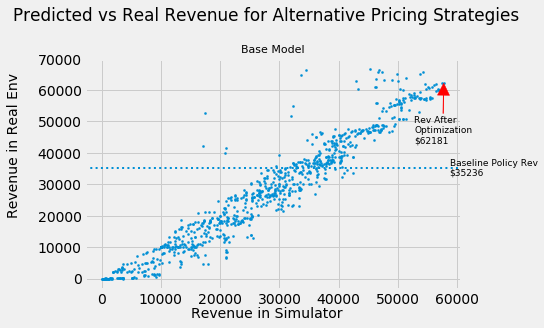

In [9]:
plot_optim_results({'Base Model': sim_revenue},
                   real_revenue,
                   baseline_real_rev=val_profits.mean())

# Bayesian Inference for More Robust Optimization

The optimization process appeared effective. How critically did this hinge on the quality of the predictive model? It's easy to test.

Each airline predicts demand each day from a "demand signal". Increasing noise in this signal will decrease the accuracy of their predictive models. With worse predictive models, the firm is optimizing based on an environment that is far from reality.

I simulate various noise levels, and use two types of predictive models:
1. A conventional Deep Learning model (as used above)
2. A Bayesian Neural Network (BNN)  [defined here](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/pymc_models.py#L16) .

Each model-based simulator runs 20 flights per candidate pricing function. In the BNN based simulator, I sample from the posterior on network weights with each flight of simulated data. So the BNN optimizes the expected value of revenue, whereas the conventional model optimizes revenue at a point estimate about the environment.

I expect the BNN to outperform the conventional model in noisy environments, and this is borne out in the results below.

---

noise level: 20
R-squared values in Conventional model: {'delta_price': 0.84, 'jb_qty_sold': 0.49, 'delta_qty_sold': 0.46}


Average Loss = 84,844: 100%|██████████| 40000/40000 [02:32<00:00, 262.74it/s]
Finished [100%]: Average Loss = 84,845


R-squared values in Bayesian model: {'jb_qty_sold': 0.53, 'delta_qty_sold': 0.49, 'delta_price': 0.33}


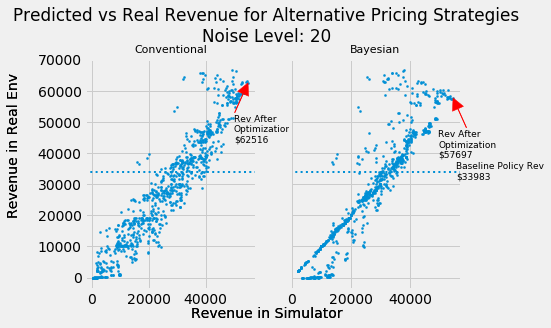

---

noise level: 100
R-squared values in Conventional model: {'delta_price': 0.23, 'jb_qty_sold': 0.28, 'delta_qty_sold': 0.2}


Average Loss = 53,428: 100%|██████████| 40000/40000 [01:24<00:00, 470.76it/s]
Finished [100%]: Average Loss = 53,428


R-squared values in Bayesian model: {'jb_qty_sold': 0.3, 'delta_qty_sold': 0.23, 'delta_price': -0.0}


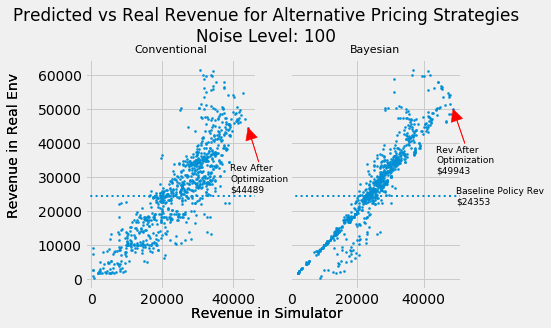

---

noise level: 250
R-squared values in Conventional model: {'delta_price': -0.11, 'jb_qty_sold': 0.46, 'delta_qty_sold': -0.12}


Average Loss = 47,181: 100%|██████████| 40000/40000 [01:20<00:00, 498.31it/s]
Finished [100%]: Average Loss = 47,180


R-squared values in Bayesian model: {'jb_qty_sold': 0.46, 'delta_qty_sold': 0.15, 'delta_price': -0.14}


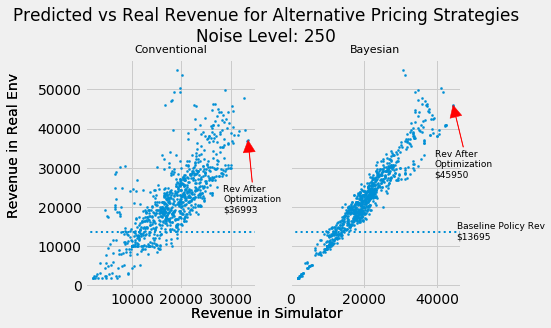

---

noise level: 500
R-squared values in Conventional model: {'delta_price': -0.12, 'jb_qty_sold': 0.58, 'delta_qty_sold': -0.09}


Average Loss = 47,937: 100%|██████████| 40000/40000 [01:20<00:00, 499.21it/s]
Finished [100%]: Average Loss = 47,937


R-squared values in Bayesian model: {'jb_qty_sold': 0.59, 'delta_qty_sold': 0.15, 'delta_price': -0.04}


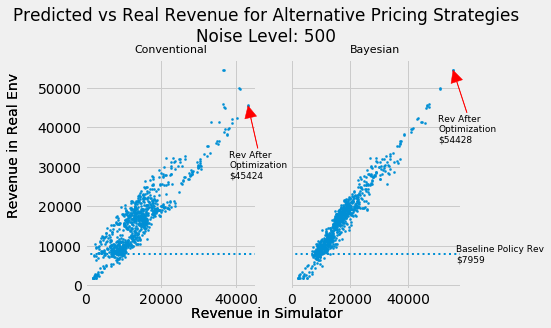

In [11]:
from sem_policy_opt.diagnostics import comparative_analysis

noise_levels = [20, 100, 250, 500]
comparative_results = comparative_analysis(real_dgp=real_dgp,
                                           models={'Conventional': WrappedKerasModel,
                                                   'Bayesian': WrappedPymcModel},
                                           market_details=market_details,
                                           flights_in_training_data=flights_in_training_data,
                                           noise_levels=noise_levels,
                                           pricing_fns=pricing_fns,
                                           baseline_price_fn=simple_price_fn)

The benefit of the BNN is especially apparent in the scatter plots. The "revenue in simulation" has fewer large errors with the BNN than with the conventional model (seen as large deviations from the 45-degree line in the scatter plots).

Policy choice depends on a first order statistic, and can thus be noisy. But tight clustering around the 45 degree line suggests that expected revenues in the BNN are good estimates of the results an agent would receive in the true market.

Optimization results at all noise levels are summarized below. The uptick at a noise level of 500 is surprising (possibly just noise), but the trend of more robust inference with the BNN is notable.

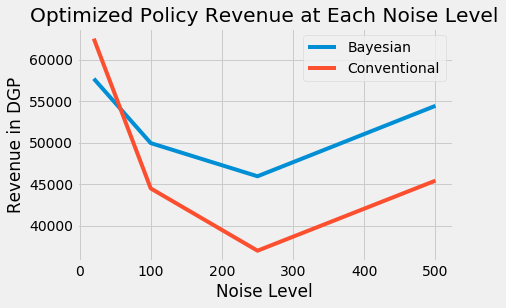

In [23]:
model_comparison_plot(comparative_results)

# Next Steps

My planned next steps are

1. Improve sampling from BNN (I don't write out details here, because I intend to change it)
2. Abstract out the logic that's universal vs use-case specific
3. This notebook optimizes in the simulator by a grid search. This will scale poorly as the state space gets larger. Re-enable the code to do optimization through the [stable_baselines](https://github.com/hill-a/stable-baselines) implementation of standard RL algorithms. The most straightforward approach to installing this in Colab and Kaggle kernels didn't work.
4. Run on real (static) dataset rather than synthetic dataset to illustrate this workflow

# Current Concerns
Price optimization nearly doubled real profits in the main example. This is robust to the amount of noise in the model. But I see three primary objections to this example:

1) This improvement is over a baseline I created through trial and error, not a policy used in the real world (I certainly don't mean to suggest that a Fortune 500 company could double revenue this easily).

2) This example is a somewhat simple problem: there are only two airlines and we didn't account for factors like seasonality. It would be straightforward to include these factors in the model, though I've yet to show how well the process works in a more complex environment.

3) Most concerning, it's unclear how to show that a policy created through optimization will work well without applying it (there's nothing like a test set from supervised ML).

I think these concerns can be addressed. Moreover, I think this workflow can have as big an impact in the next 10 years as what enterprise adoption of supervised ML has had in the last 10 years.

# Appendix

### Optimization Through Modern Reinforcement Learning

The cell below optimizes the pricing policy with Soft Actor Critic (SAC), an RL algorithm that is sample efficient and which is reported to require little hyperparameter tuning.

NOTE: I am sharing this notebook output in Kaggle Kernels. I've not yet been able to install `stable_baselines` in kernels, so I've commented this part out for now. The value of my underlying approach doesn't hinge on whether I do optimization through SAC, grid search (used above) or something else

In [ ]:
if False:    # disabled until I install stable_baselines in Kernels
    from stable_baselines.common.vec_env import DummyVecEnv
    from stable_baselines.sac.policies import MlpPolicy
    from stable_baselines.sac import SAC
    from time import time
    import os

    sim_market_maker = lambda: market_maker(sim_market_conditions)
    
    parallelism_level = 1         # use os.cpu_count() if not using SAC. SAC doesn't allow parallelism
    env = DummyVecEnv([sim_market_maker for _ in range(parallelism_level)]) # Env is vectorized market for parallelism
    total_learning_steps = 750000
    steps_per_update = 10000
    optim_results = []

    model = SAC(MlpPolicy, env)

    start_time = time()
    for step in range(0, total_learning_steps+1, steps_per_update):
        model.learn(total_timesteps=steps_per_update)
    
        mean_sim_reward = run_env(sim_market_maker, model, n_times=5)[0].mean()
        mean_real_reward = run_env(real_market_maker, model, n_times=5)[0].mean()
        optim_results.append(dict(step=step, 
                                  time=time()-start_time,
                                  sim_profit=mean_sim_reward,
                                  real_profit=mean_real_reward))
    
        print("""{} timesteps used for learning in {:.0f} seconds. 
                 Current score in sim: {:.0f}. Current score in real market: {:.0f}.""".format(
                                                                                step,
                                                                                time()-start_time, 
                                                                                mean_sim_reward, 
                                                                                mean_real_reward))
    optim_results_df = pd.DataFrame(optim_results)
    optim_results_df.plot.line(x='step', y=['sim_profit', 'real_profit'])